### Cleaning Indeed Reviews Data

The goal from this dataset is to figure out:
- How different industries affect the work quality
- How different ranks affect the work quality
- How different occupations affect the work quality

### Basic Imports

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

In [153]:
review_data = pd.read_excel('Datasets/webscraping_indeed_unique_reviews_24112020.xlsx');

review_data.head(3)

,_OccupationRole,_Rank,Author,Company,Date,Employment,Occupation,Place,Review Raw,Review Removed Punctuation,Review Stopwords Removed,ReviewStopwordsRemoved2,Table Name,Rating
0,Sales,NaN,Retail Assistant (Former Employee) - City Hall...,Charles-&-Keith,2019-11-23,Former Employee,Retail Assistant,City Hall,Eazy cash for student who want to earn extra p...,Eazy cash for student who want to earn extra p...,"['eazy', 'cash', 'student', 'want', 'earn', 'e...",eazy cash student want earn extra pocket money...,webscraping_indeed_reviews_Charles-&-Keith2411...,3
1,NaN,NaN,Fashion Advisor (Former Employee) - Jurong poi...,Charles-&-Keith,2020-07-07,Former Employee,Fashion Advisor,Jurong point,Working in Charles and Keith is definitely a g...,Working in Charles and Keith is definitely a g...,"['working', 'charles', 'keith', 'definitely', ...",working charles keith definitely good opportun...,webscraping_indeed_reviews_Charles-&-Keith2411...,5
2,NaN,Manager,Boutique Manager (Current Employee) - Singapor...,Charles-&-Keith,2020-04-01,Current Employee,Boutique Manager,Singapore,Charles and Keith is a well known local brand ...,Charles and Keith is a well known local brand ...,"['charles', 'keith', 'well', 'known', 'local',...",charles keith well known local brand singapore...,webscraping_indeed_reviews_Charles-&-Keith2411...,3


---

We have the following features

ReviewStopwordsRemoved:
  - This can help us figure out type of benefits
  
Rank:
  - Position of the person

Occupation:
  - What jobs they do. This can help us get the industry
 
OccupationRole:
  - Effectively just what department they work at (e.g. a Lawyer in OCBC will still fall under law occupation Role)


---

In [154]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315 entries, 0 to 3314
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   _OccupationRole             1870 non-null   object        
 1   _Rank                       956 non-null    object        
 2   Author                      3315 non-null   object        
 3   Company                     3315 non-null   object        
 4   Date                        3315 non-null   datetime64[ns]
 5   Employment                  3315 non-null   object        
 6   Occupation                  3305 non-null   object        
 7   Place                       3312 non-null   object        
 8   Review Raw                  3314 non-null   object        
 9   Review Removed Punctuation  3315 non-null   object        
 10  Review Stopwords Removed    3149 non-null   object        
 11  ReviewStopwordsRemoved2     3066 non-null   object      

In [155]:
# Dropping rows and columns
review_data.drop(columns=['Table Name'] , inplace=True)
review_data.dropna(subset=['Occupation' , 'Review Raw' , 'Review Stopwords Removed'] , inplace=True)

### Industry and Occupation

In [156]:
print(review_data['Company'].unique())
print(review_data['_OccupationRole'].unique())
print(review_data['Occupation'].unique())
review_data[['Occupation' , 'Company']]

## There are only 10 unique companies, i can just manually label each based on their industry
## There is alot of occupation 

['Charles-&-Keith' 'Dbs-Bank' 'Giordano' 'Isetann-Department-Store'
 'M1-Limited' 'Ocbc-Bank' 'Singtel' 'Uniqlo' 'United-Overseas-Bank']
['Sales' nan 'Customer Service' 'Product' 'Marketing' 'Technician'
 'Analysts' 'Business Development' 'Administration' 'Engineering'
 'Finance/Accounts' 'Project Management']
['Retail Assistant' 'Fashion Advisor' 'Boutique Manager' ...
 'Part Time Bank Teller' 'contract staff' 'Senior Loans Manager']


,Occupation,Company
0,Retail Assistant,Charles-&-Keith
1,Fashion Advisor,Charles-&-Keith
2,Boutique Manager,Charles-&-Keith
3,Retail Assistant,Charles-&-Keith
4,Sales Associate,Charles-&-Keith
...,...,...
3310,Senior officer,United-Overseas-Bank
3311,Supervisor,United-Overseas-Bank
3312,Associate Officer,United-Overseas-Bank
3313,contract staff,United-Overseas-Bank


In [157]:
## handling industry (easy)
company_to_industry_map = {
  'Charles-&-Keith': 'Fashion Retail',
  'Dbs-Bank': 'Banking & Finance',
  'Giordano': 'Apparel Retail',
  'Isetann-Department-Store': 'General Retail',
  'M1-Limited': 'Telecommunications',
  'Ocbc-Bank': 'Banking & Finance',
  'Singtel': 'Telecommunications',
  'Uniqlo': 'Fashion Retail',
  'United-Overseas-Bank': 'Banking & Finance',
  'Starhub': 'Telecommunications',
}

def createIndustry(company_name):
  global company_to_industry_map
  return company_to_industry_map[company_name]


review_data['Industry'] = review_data['Company'].apply(createIndustry)

review_data['Industry']

0          Fashion Retail
1          Fashion Retail
2          Fashion Retail
3          Fashion Retail
4          Fashion Retail
              ...        
3310    Banking & Finance
3311    Banking & Finance
3312    Banking & Finance
3313    Banking & Finance
3314    Banking & Finance
Name: Industry, Length: 3138, dtype: object

### Keyword Selection For Occupational Roles

In [158]:
department_keywords = {
    'Sales': [
        'sales', 'associate', 'account executive', 'business development',
        'representative', 'retail', 'promoter', 'consultant', 'telesales',
        'cashier', 'client advisor', 'store', 'floor staff', 'merchandiser',
        'customer advisor'
    ],
    'Customer Service': [
        'customer service', 'service representative', 'call center', 'support',
        'helpdesk', 'advisor', 'client care', 'relationship officer',
        'service associate', 'service coordinator', 'support specialist',
        'care officer'
    ],
    'Product': [
        'product manager', 'product owner', 'product specialist',
        'product designer', 'vendor', 'merchandiser', 'visual merchandiser',
        'inventory', 'product developer', 'product coordinator'
    ],
    'Marketing': [
        'marketing', 'brand manager', 'digital marketing', 'content creator',
        'seo', 'sem', 'social media', 'campaign manager', 'media buyer',
        'advertising', 'communications', 'promoter', 'public relations'
    ],
    'Technician': [
        'technician', 'maintenance', 'field tech', 'repair',
        'technical support', 'it technician', 'systems technician',
        'network technician', 'engineering tech'
    ],
    'Analysts': [
        'analyst', 'data analyst', 'business analyst', 'research', 'insights',
        'reporting', 'financial analyst', 'market analyst', 'operations analyst'
    ],
    'Business Development': [
        'business development', 'partnership manager', 'growth manager',
        'strategic partnerships', 'sales development', 'alliances',
        'account manager', 'commercial manager'
    ],
    'Administration': [
        'administration', 'admin', 'secretary', 'executive assistant',
        'office manager', 'clerk', 'receptionist', 'coordinator',
        'office assistant', 'administrative officer'
    ],
    'Engineering': [
        'engineer', 'software engineer', 'mechanical engineer',
        'electrical engineer', 'civil engineer', 'systems engineer',
        'network engineer', 'developer', 'full stack', 'backend', 'frontend',
        'technical lead'
    ],
    'Finance/Accounts': [
        'finance', 'accounting', 'accountant', 'financial officer', 'treasury',
        'auditor', 'controller', 'accounts payable', 'accounts receivable',
        'investment', 'banking', 'credit analyst'
    ],
    'Project Management': [
        'project manager', 'program manager', 'scrum master', 'agile coach',
        'project coordinator', 'delivery manager', 'project lead',
        'implementation manager'
    ],
    'Management': [
      'manager',  'supervisor', 'director', 'team lead', 'coordinator',
    'executive', 'administrator', 'chief', 'head of', 'lead',  
    ]
}


def imputeOccupationRole(row):
  value = row['Occupation']
  occupation_role = row['_OccupationRole']

  # no impute non-null values
  if pd.notna(occupation_role):
     return occupation_role

  global department_keywords
  occupation_list = value.lower().split(' ')

  for key , keywords_list in department_keywords.items():

    # going through the keywords for given key
    for keyword in keywords_list:
        if keyword in occupation_list:
           return key
        
        if len(keyword.split(' ')) > 1: # For words like 'program manager'
           if keyword in value.lower():  # direct check if exists in occupation
             return key
  
  ## Unable to group, return nan
  return np.nan


review_data['_OccupationRole'] = review_data.apply(imputeOccupationRole , axis=1)


In [159]:
review_data[['_OccupationRole' , 'Occupation']]

,_OccupationRole,Occupation
0,Sales,Retail Assistant
1,Customer Service,Fashion Advisor
2,Management,Boutique Manager
3,Sales,Retail Assistant
4,Sales,Sales Associate
...,...,...
3310,NaN,Senior officer
3311,Management,Supervisor
3312,Sales,Associate Officer
3313,NaN,contract staff


### Benefits Extraction

In [160]:
# Using LDA to extract the occupation departments
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# vectorising the occupations
vectoriser = CountVectorizer(stop_words="english")
data_matrix = vectoriser.fit_transform(review_data['Review Stopwords Removed'].values.flatten())
features = vectoriser.get_feature_names_out()

In [161]:
def displayTopicsKeywords(components):
  for index , topic in enumerate(components):
    features_index = topic.argsort()[::-1][:5]
    likely_features = [features[i] for i in features_index]
    print(f"Topic {index + 1}: {likely_features}")

In [162]:
for k in range(20, 31):
  lda= LatentDirichletAllocation(n_components= k , random_state=42)
  lda.fit(data_matrix)
  print('-----------------------------------------')
  print(f'Results for n-topics = {k}')
  displayTopicsKeywords(lda.components_)

-----------------------------------------
Results for n-topics = 20
Topic 1: ['good', 'work', 'company', 'great', 'job']
Topic 2: ['work', 'good', 'working', 'environment', 'team']
Topic 3: ['les', 'des', 'pour', 'vous', 'très']
Topic 4: ['job', 'like', 'improvement', 'store', 'product']
Topic 5: ['travail', 'très', 'est', 'bonne', 'une']
Topic 6: ['job', 'customers', 'people', 'learned', 'work']
Topic 7: ['store', 'sales', 'work', 'job', 'day']
Topic 8: ['work', 'life', 'day', 'balance', 'place']
Topic 9: ['management', 'company', 'time', 'learning', 'project']
Topic 10: ['work', 'customers', 'sales', 'job', 'working']
Topic 11: ['work', 'company', 'job', 'que', 'managers']
Topic 12: ['die', 'und', 'das', 'real', 'clients']
Topic 13: ['management', 'clients', 'culture', 'environment', 'working']
Topic 14: ['customer', 'service', 'customers', 'work', 'job']
Topic 15: ['management', 'job', 'skills', 'customer', 'learn']
Topic 16: ['work', 'job', 'people', 'time', 'store']
Topic 17: ['co

In [163]:
# Though a brief view of the data, i decided to take the results for n-topic  = 25
# Using the existing values of 
lda= LatentDirichletAllocation(n_components= 25 , random_state=42)
lda.fit(data_matrix)
displayTopicsKeywords(lda.components_)


Topic 1: ['work', 'good', 'job', 'company', 'great']
Topic 2: ['work', 'good', 'management', 'environment', 'company']
Topic 3: ['management', 'staff', 'working', 'day', 'culture']
Topic 4: ['people', 'store', 'job', 'management', 'sales']
Topic 5: ['les', 'très', 'est', 'une', 'bonne']
Topic 6: ['people', 'work', 'new', 'job', 'great']
Topic 7: ['high', 'store', 'job', 'hour', 'work']
Topic 8: ['work', 'day', 'life', 'job', 'new']
Topic 9: ['management', 'project', 'time', 'need', 'projects']
Topic 10: ['customers', 'work', 'job', 'employees', 'calls']
Topic 11: ['que', 'work', 'managers', 'working', 'culture']
Topic 12: ['die', 'und', 'company', 'das', 'managers']
Topic 13: ['les', 'des', 'que', 'pour', 'vous']
Topic 14: ['customers', 'work', 'customer', 'dont', 'managers']
Topic 15: ['management', 'employees', 'new', 'job', 'staff']
Topic 16: ['time', 'work', 'job', 'skills', 'people']
Topic 17: ['company', 'employees', 'management', 'review', 'work']
Topic 18: ['work', 'store', 'co

In [164]:
# After breif analysis, can create a map of what each review main topic is about again its 
topic_groups = {
    'Work Environment & Culture': [1, 2, 3, 8, 21, 22],
    'Management & Staff': [3, 9, 11, 15, 17, 19],
    'Customer Relations': [10, 14, 24, 25],
    'Job & Career Growth': [6, 16, 23],
    'Retail & Store Experience': [4, 7, 18],
    'Foreign': [5, 12, 13],
    'Financial/Banking': [20, 25],
}


topic_weights = lda.transform(data_matrix)
topic_weights = np.argmax(topic_weights , axis=1) + 1 # get the max weight index in each row 

def createReviewTopic(index):
  for key , indices in topic_groups.items():
    if index in indices:
      return key


review_data['topic_weights'] = topic_weights
review_data['review_topics'] = review_data['topic_weights'].apply(createReviewTopic)



In [165]:
# Using blox text sentiment, i will extract the polarity and subjectivity
from textblob import TextBlob

def extractSentiment(review):
  sentiment = TextBlob(review).sentiment
  return pd.Series([sentiment.polarity , sentiment.subjectivity])

review_data[['review polarity' , 'review subjectivity']] = review_data['Review Raw'].apply(extractSentiment)

In [166]:
## Final display of table head to show all changes made
review_data.head(3)

,_OccupationRole,_Rank,Author,Company,Date,Employment,Occupation,Place,Review Raw,Review Removed Punctuation,Review Stopwords Removed,ReviewStopwordsRemoved2,Rating,Industry,topic_weights,review_topics,review polarity,review subjectivity
0,Sales,NaN,Retail Assistant (Former Employee) - City Hall...,Charles-&-Keith,2019-11-23,Former Employee,Retail Assistant,City Hall,Eazy cash for student who want to earn extra p...,Eazy cash for student who want to earn extra p...,"['eazy', 'cash', 'student', 'want', 'earn', 'e...",eazy cash student want earn extra pocket money...,3,Fashion Retail,2,Work Environment & Culture,0.100000,0.500000
1,Customer Service,NaN,Fashion Advisor (Former Employee) - Jurong poi...,Charles-&-Keith,2020-07-07,Former Employee,Fashion Advisor,Jurong point,Working in Charles and Keith is definitely a g...,Working in Charles and Keith is definitely a g...,"['working', 'charles', 'keith', 'definitely', ...",working charles keith definitely good opportun...,5,Fashion Retail,22,Work Environment & Culture,0.366667,0.533333
2,Management,Manager,Boutique Manager (Current Employee) - Singapor...,Charles-&-Keith,2020-04-01,Current Employee,Boutique Manager,Singapore,Charles and Keith is a well known local brand ...,Charles and Keith is a well known local brand ...,"['charles', 'keith', 'well', 'known', 'local',...",charles keith well known local brand singapore...,3,Fashion Retail,2,Work Environment & Culture,0.138889,0.352778


### Plottings

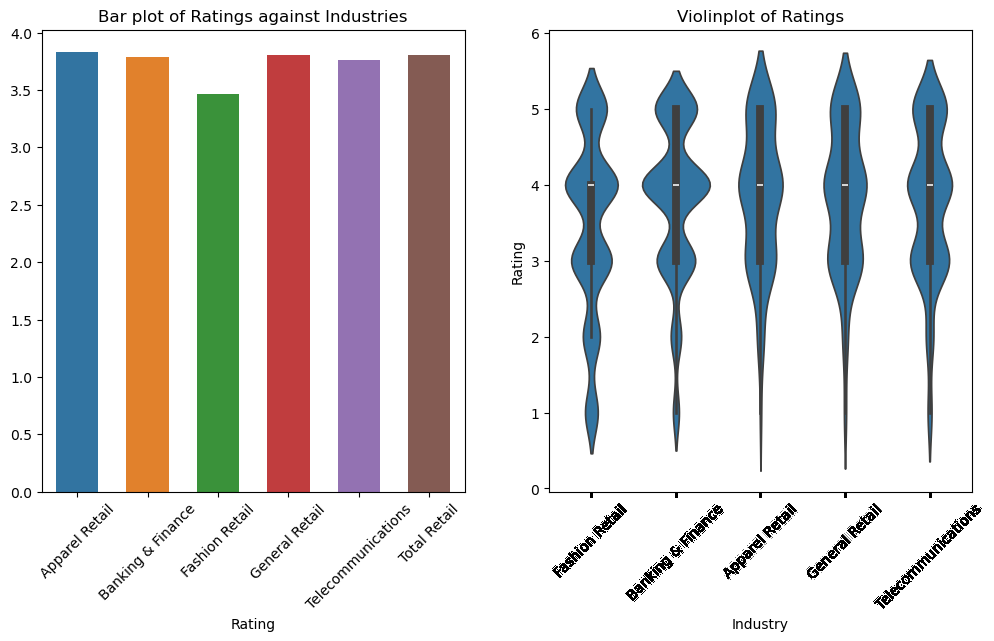

,Rating
Industry,
Apparel Retail,3.833333
Banking & Finance,3.786444
Fashion Retail,3.467218
General Retail,3.805556
Telecommunications,3.758389
Total Retail,3.805556


In [167]:
grouped_by_industry = review_data[['Industry' , 'Rating']].groupby(by='Industry').mean()

# I also want to 'group' the retails tgt
mean_retail_rating = grouped_by_industry.loc[['General Retail' , 'Apparel Retail' ,'Fashion Retail'] , :].median()

# adding to the df
grouped_by_industry.loc['Total Retail'] = mean_retail_rating

# Plottings
X = grouped_by_industry.index
y = grouped_by_industry['Rating'].values

fig , axes = plt.subplots(1 , 2 ,figsize=(12 , 6))

# Bar plot
sns.barplot(x=X , y=y , hue=X , width=0.6 , ax=axes[0])
axes[0].set_xticks(ticks=X , labels=X , rotation=45)
axes[0].set_xlabel('Rating')
axes[0].set_title('Bar plot of Ratings against Industries')


# Box plot
X = review_data['Industry']
sns.violinplot(x=X , y=review_data['Rating'] , ax=axes[1])
axes[1].set_xticks(ticks=X, labels=X , rotation=45)
axes[1].set_title('Violinplot of Ratings')

plt.show()

grouped_by_industry